In [1]:
!pip install opendatasets
!pip install keras.preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


In [15]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
od.download("https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer?select=train")
od.download("https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer?select=test")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dfghdfghd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer


100%|██████████| 65.2M/65.2M [00:00<00:00, 627MB/s]

Skipping, found downloaded files in "./emotion-detection-fer" (use force=True to force download)


In [5]:

data_path = "/content/emotion-detection-fer"
data = os.listdir(data_path)
print(data)

['train', 'test']


In [6]:
for split in data:
    split_path = os.path.join(data_path, split)
    classes = os.listdir(split_path)
    print(f"{split} classes:", classes)

    counts = {cls: len(os.listdir(os.path.join(split_path, cls))) for cls in classes}
    print(f"{split} samples per class:", counts)

train classes: ['surprised', 'fearful', 'neutral', 'sad', 'disgusted', 'happy', 'angry']
train samples per class: {'surprised': 3171, 'fearful': 4097, 'neutral': 4965, 'sad': 4830, 'disgusted': 436, 'happy': 7215, 'angry': 3995}
test classes: ['surprised', 'fearful', 'neutral', 'sad', 'disgusted', 'happy', 'angry']
test samples per class: {'surprised': 831, 'fearful': 1024, 'neutral': 1233, 'sad': 1247, 'disgusted': 111, 'happy': 1774, 'angry': 958}


# Data normalization

In [7]:
train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# preprocessing train data

In [8]:
train_gen = train_data_generator.flow_from_directory(
    "/content/emotion-detection-fer/train",
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

test_gen = test_data_generator.flow_from_directory(
    '/content/emotion-detection-fer/test',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))

# Model archticture

In [10]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the neural network/model

In [12]:
emotion_model_info = emotion_model.fit(
    train_gen,
    steps_per_epoch=28709 // 64,
    epochs=50,
    validation_data=test_gen,
    validation_steps=7178 // 64,
    class_weight=class_weights
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.1455 - loss: 1.9301 - val_accuracy: 0.2521 - val_loss: 1.8597
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.2188 - loss: 2.2737

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2188 - loss: 2.2737 - val_accuracy: 0.2440 - val_loss: 1.8658
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2332 - loss: 1.8643 - val_accuracy: 0.3333 - val_loss: 1.7266
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2344 - loss: 2.5114 - val_accuracy: 0.3304 - val_loss: 1.7333
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.3254 - loss: 1.7320 - val_accuracy: 0.3874 - val_loss: 1.6295
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3750 - loss: 2.3336 - val_accuracy: 0.3874 - val_loss: 1.6314
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3706 - loss: 1.6288 - val_accuracy: 0.3564 - val_loss: 1.6583
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4062 - loss: 1.6169 - val_accuracy: 0.3528 - val_loss: 1.6639
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.4004 - loss: 1.5638 - val_accuracy: 0.38

# save model

In [13]:
# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model.weights.h5')

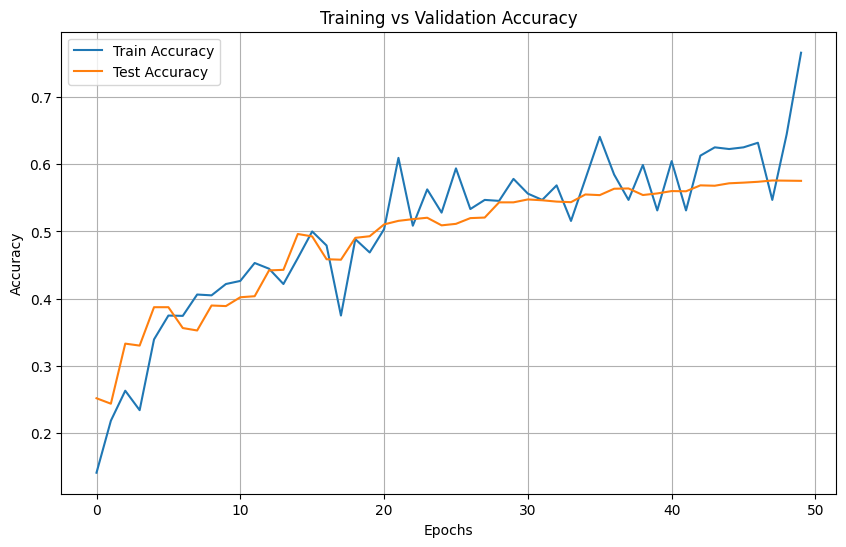

In [16]:
history = emotion_model_info.history

plt.figure(figsize=(10, 6))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step


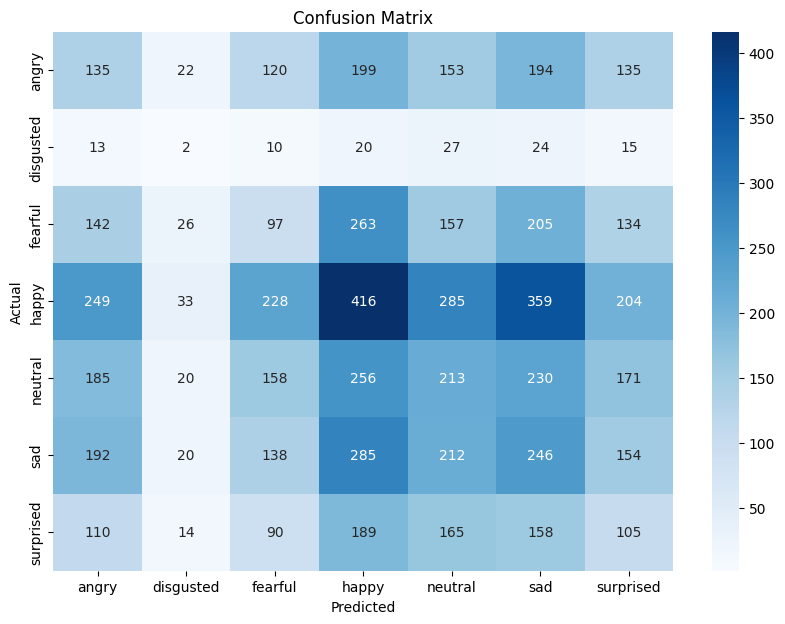

In [17]:
# Get true labels
y_true = test_gen.classes

# Predict probabilities
y_pred_probs = emotion_model.predict(test_gen)
# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
target_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
   disgusted       0.01      0.02      0.02       111
     fearful       0.12      0.09      0.10      1024
       happy       0.26      0.23      0.24      1774
     neutral       0.18      0.17      0.17      1233
         sad       0.17      0.20      0.18      1247
   surprised       0.11      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178

